In [ ]:
from model import *
from src.problem.prb import Analytic

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
an = Analytic(device)

act_func=lambda x: torch.tanh(x)

V_NN = V_Net(dim=2, ns=128, act_func=act_func, hh=0.5,
                            device=device, psi_func=an.psi_func, TT=1).to(device)

V_NN.load_state_dict(torch.load('V_NN_d2.pth'))



<All keys matched successfully>

In [ ]:
from IPython.display import clear_output
import numpy as np
from scipy.integrate import solve_ivp, solve_bvp
import time

N = 20

def eval_u(t, x):
        u = V_NN.get_grad(t, x).detach().cpu().numpy()
        return u

X_OUT = np.empty((0, an.dim))
t_OUT = np.empty((0, 1))

num_samples = 32

data = an.gen_x0(num_samples, Torch=False)

Ns_sol = 0
start_time = time.time()

while Ns_sol < num_samples:

    print('Solving IVP #', Ns_sol+1, '...', end='\r')

    X0 = data[Ns_sol, :]

    # Integrates the closed-loop system (NN controller)

    SOL = solve_ivp(an.dynamics, [0., 1], X0,
                    method= 'RK23', t_eval=np.linspace(0,1,N+1),
                    args=(eval_u,),
                    rtol=1e-08)



    Ns_sol += 1

    t_OUT = np.vstack((t_OUT, SOL.t.reshape(1,-1).T))
    X_OUT = np.vstack((X_OUT, SOL.y.T))


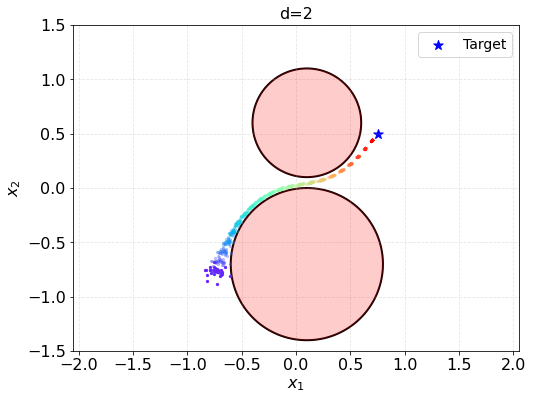

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def circular_obstacle(self, x, y, center, radius):
        """
        Defines a circular obstacle.
        """
        dist_squared = (x - center[0])**2 + (y - center[1])**2
        return radius**2 - dist_squared

    def smooth_max(self, f1, f2, smoothness=10.0):
        return (1 / smoothness) * np.log(np.exp(smoothness * f1) + np.exp(smoothness * f2))

    def FF_obstacle_func(self, x, y):
        """
        Combines two circular obstacles with smooth maximum.
        """
        obstacle1 = self.circular_obstacle(x, y, center=[0.1, 0.6], radius=0.5)
        obstacle2 = self.circular_obstacle(x, y, center=[0.1, -0.7], radius=0.7)
        return np.maximum(obstacle1, obstacle2)

    def _make_obstacle_contours(self):
        """
        Prepares contour grid for obstacle field visualization.
        """
        self.plot_window_size = 1.5
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z


# Initialize obstacle field
obstacle_field = ObstacleField()

# Generate contours
X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

timesteps = 20

with torch.no_grad():
    # Generate contour data for obstacles
    obstacle_field = ObstacleField()
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

    # Obstacle centers and radii for adding lines
    obstacles = [
        {"center": [0.1, 0.6], "radius": 0.5},
        {"center": [0.1, -0.7], "radius": 0.7},
    ]

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))

    # Add contour lines for obstacles
    contour = ax.contour(
        X_contour, Y_contour, Z_contour,
        levels=[0],  # Contour for the obstacle boundary
        colors='black',
        linewidths=2,
        zorder=1
    )

    # Add filled circles for obstacles
    for obs in obstacles:
        circle = plt.Circle(obs["center"], obs["radius"], color="red", alpha=0.2, zorder=2)
        ax.add_patch(circle)

    # Plot the trajectory with colors for each timestep
    color = iter(cm.rainbow(np.linspace(0, 1, timesteps + 2)))
    next(color)  # Skip the first color

    for time_idx in range(0, timesteps + 1):
        c = next(color)

        # Select plot samples
        plot_sample = X_OUT.reshape(32, 21, 2)[0:64, time_idx, 0:10]

        # Set transparency
        alpha = 1 if (time_idx == 0 or time_idx == timesteps) else 0.3

        # Scatter plot for points at each time step
        ax.scatter(
            plot_sample[:, 0],
            plot_sample[:, 1],
            color=c,
            alpha=alpha,
            zorder=10,
            s=5,
            label="" if time_idx == 0 else ""  # Add label only once for the legend
        )

    # Mark final target point
    ax.scatter(0.75, 0.5, color='b', marker='*', s=100, label="Target")

    # Adjust plot limits and labels
    ax.set_title("d=2", fontsize=16)
    ax.set_xlabel(r"$x_1$", fontsize=16, fontweight='bold')
    ax.set_ylabel(r"$x_2$", fontsize=16, fontweight='bold')
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.3)

    ax.tick_params(axis='both', which='major', labelsize=16)

    # Add legend
    ax.legend(fontsize=14, loc="upper right")

    # Save and display the plot
    plt.savefig('obs_2d.png', dpi=300)
    plt.show()


In [ ]:
from model import *
from src.problem.prb import Analytic

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
an = Analytic(device)

act_func=lambda x: torch.tanh(x)

V_NN = V_Net(dim=10, ns=128, act_func=act_func, hh=0.5,
                            device=device, psi_func=an.psi_func, TT=1).to(device)

V_NN.load_state_dict(torch.load('V_NN_d10.pth'))



<All keys matched successfully>

In [ ]:
from IPython.display import clear_output
import numpy as np
from scipy.integrate import solve_ivp, solve_bvp

N = 20

def eval_u(t, x):
        u = V_NN.get_grad(t, x).detach().cpu().numpy()
        return u

X_OUT = np.empty((0, an.dim))
t_OUT = np.empty((0, 1))

num_samples = 32

data = an.gen_x0(num_samples, Torch=False)

Ns_sol = 0


while Ns_sol < num_samples:

    print('Solving IVP #', Ns_sol+1, '...', end='\r')

    X0 = data[Ns_sol, :]

    # Integrates the closed-loop system (NN controller)

    SOL = solve_ivp(an.dynamics, [0., 1], X0,
                    method= 'RK23', t_eval=np.linspace(0,1,N+1),
                    args=(eval_u,),
                    rtol=1e-08)



    Ns_sol += 1

    t_OUT = np.vstack((t_OUT, SOL.t.reshape(1,-1).T))
    X_OUT = np.vstack((X_OUT, SOL.y.T))


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm


class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def circular_obstacle(self, x, y, center, radius):
        """
        Defines a circular obstacle.
        """
        dist_squared = (x - center[0])**2 + (y - center[1])**2
        return radius**2 - dist_squared

    def smooth_max(self, f1, f2, smoothness=10.0):
        return (1 / smoothness) * np.log(np.exp(smoothness * f1) + np.exp(smoothness * f2))

    def FF_obstacle_func(self, x, y):
        """
        Combines two circular obstacles with smooth maximum.
        """
        obstacle1 = self.circular_obstacle(x, y, center=[0.1, 0.6], radius=0.5)
        obstacle2 = self.circular_obstacle(x, y, center=[0.1, -0.7], radius=0.7)
        return np.maximum(obstacle1, obstacle2)

    def _make_obstacle_contours(self):
        """
        Prepares contour grid for obstacle field visualization.
        """
        self.plot_window_size = 1.5
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z


# Initialize obstacle field
obstacle_field = ObstacleField()

# Generate contours
X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

timesteps = N

with torch.no_grad():
    # Generate contour data for obstacles
    obstacle_field = ObstacleField()
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

    # Obstacle centers and radii for adding lines
    obstacles = [
        {"center": [0.1, 0.6], "radius": 0.5},
        {"center": [0.1, -0.7], "radius": 0.7},
    ]

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))

    # Add contour lines for obstacles
    contour = ax.contour(
        X_contour, Y_contour, Z_contour,
        levels=[0],  # Contour for the obstacle boundary
        colors='black',
        linewidths=2,
        zorder=1
    )

    # Add lines inside the obstacles to visually represent them
    # Add filled circles for obstacles
    for obs in obstacles:
        circle = plt.Circle(obs["center"], obs["radius"], color="red", alpha=0.2, zorder=2)
        ax.add_patch(circle)


    # Plot the trajectory with colors for each timestep
    color = iter(cm.rainbow(np.linspace(0, 1, timesteps + 2)))
    next(color)  # Skip the first color

    for time_idx in range(0, timesteps + 1):
        c = next(color)

        # Select plot samples
        plot_sample = X_OUT.reshape(32, 21, 10)[0:64, time_idx, 0:10]

        # Set transparency
        alpha = 1 if (time_idx == 0 or time_idx == timesteps) else 0.3

        # Scatter plot for points at each time step
        ax.scatter(
            plot_sample[:, 0],
            plot_sample[:, 1],
            color=c,
            alpha=alpha,
            zorder=10,
            s=5
        )
    ax.scatter(0.75, 0.5, color='b', marker='*', s=100, label="Target")

    # Adjust plot limits and labels
    ax.set_title(" d= 10", fontsize=16)
    ax.set_xlabel(r"$x_1$", fontsize=16, fontweight='bold')
    ax.set_ylabel(r"$x_2$", fontsize=16, fontweight='bold')
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.3)

    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.legend(fontsize=14, loc="upper right")

    plt.savefig('obs_10.png', dpi=300)
    plt.show()



In [ ]:
from model import *
from src.problem.prb import Analytic

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
an = Analytic(device)

act_func=lambda x: torch.tanh(x)

V_NN = V_Net(dim=50, ns=128, act_func=act_func, hh=0.5,
                            device=device, psi_func=an.psi_func, TT=1).to(device)

V_NN.load_state_dict(torch.load('V_NN_d50.pth'))



<All keys matched successfully>

In [ ]:
from IPython.display import clear_output
import numpy as np
from scipy.integrate import solve_ivp, solve_bvp

N = 20

def eval_u(t, x):
        u = V_NN.get_grad(t, x).detach().cpu().numpy()
        return u

X_OUT = np.empty((0, an.dim))
t_OUT = np.empty((0, 1))

num_samples = 32

data = an.gen_x0(num_samples, Torch=False)

Ns_sol = 0


while Ns_sol < num_samples:

    print('Solving IVP #', Ns_sol+1, '...', end='\r')

    X0 = data[Ns_sol, :]

    # Integrates the closed-loop system (NN controller)

    SOL = solve_ivp(an.dynamics, [0., 1], X0,
                    method= 'RK23', t_eval=np.linspace(0,1,N+1),
                    args=(eval_u,),
                    rtol=1e-08)



    Ns_sol += 1

    t_OUT = np.vstack((t_OUT, SOL.t.reshape(1,-1).T))
    X_OUT = np.vstack((X_OUT, SOL.y.T))


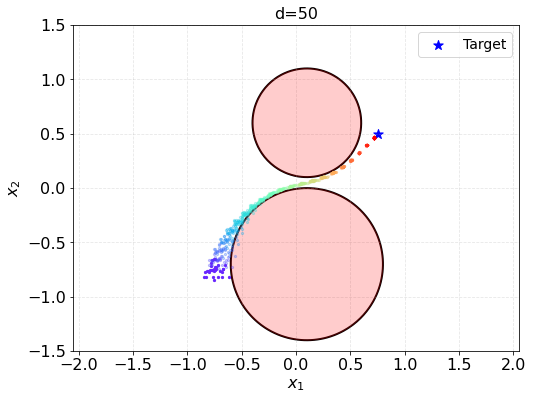

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm


class ObstacleField:
    def __init__(self, linspace_size=100, lam_obstacle=1.0):
        self.linspace_size = linspace_size
        self.env = lambda: None
        self.env.lam_obstacle = lam_obstacle

    def circular_obstacle(self, x, y, center, radius):
        """
        Defines a circular obstacle.
        """
        dist_squared = (x - center[0])**2 + (y - center[1])**2
        return radius**2 - dist_squared

#     def smooth_max(self, f1, f2, smoothness=10.0):
#         return (1 / smoothness) * np.log(np.exp(smoothness * f1) + np.exp(smoothness * f2))

    def smooth_max(self, f1, f2, smoothness=50.0):

        exp_f1 = np.exp(smoothness * f1)
        exp_f2 = np.exp(smoothness * f2)
        return (f1 * exp_f1 + f2 * exp_f2) / (exp_f1 + exp_f2)

    def FF_obstacle_func(self, x, y):
        """
        Combines two circular obstacles with smooth maximum.
        """
        obstacle1 = self.circular_obstacle(x, y, center=[0.1, 0.6], radius=0.5)
        obstacle2 = self.circular_obstacle(x, y, center=[0.1, -0.7], radius=0.7)
        return self.smooth_max(obstacle1, obstacle2)

    def _make_obstacle_contours(self):
        """
        Prepares contour grid for obstacle field visualization.
        """
        self.plot_window_size = 1.5
        xlin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        ylin = np.linspace(-self.plot_window_size, self.plot_window_size, self.linspace_size)
        X, Y = np.meshgrid(xlin, ylin)
        vec_func = np.vectorize(self.FF_obstacle_func)
        Z = self.env.lam_obstacle * vec_func(X, Y)
        return X, Y, Z


# Initialize obstacle field
obstacle_field = ObstacleField()

# Generate contours
X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

timesteps=N


with torch.no_grad():
    # Generate contour data for obstacles
    obstacle_field = ObstacleField()
    X_contour, Y_contour, Z_contour = obstacle_field._make_obstacle_contours()

    # Obstacle centers and radii for adding lines
    obstacles = [
        {"center": [0.1, 0.6], "radius": 0.5},
        {"center": [0.1, -0.7], "radius": 0.7},
    ]

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))

    # Add contour lines for obstacles
    contour = ax.contour(
        X_contour, Y_contour, Z_contour,
        levels=[0],  # Contour for the obstacle boundary
        colors='black',
        linewidths=2,
        zorder=1
    )

    # Add filled circles for obstacles
    for obs in obstacles:
        circle = plt.Circle(obs["center"], obs["radius"], color="red", alpha=0.2, zorder=2)
        ax.add_patch(circle)

    # Plot the trajectory with colors for each timestep
    color = iter(cm.rainbow(np.linspace(0, 1, timesteps + 2)))
    next(color)  # Skip the first color

    for time_idx in range(0, timesteps + 1):
        c = next(color)

        # Select plot samples
        plot_sample = X_OUT.reshape(32, 21, 50)[0:64, time_idx, 0:10]

        # Set transparency
        alpha = 1 if (time_idx == 0 or time_idx == timesteps) else 0.3

        # Scatter plot for points at each time step
        ax.scatter(
            plot_sample[:, 0],
            plot_sample[:, 1],
            color=c,
            alpha=alpha,
            zorder=10,
            s=5
        )
    ax.scatter(0.75, 0.5, color='b', marker='*', s=100, label="Target")

    # Adjust plot limits and labels
    ax.set_title("d=50", fontsize=16)
    ax.set_xlabel(r"$x_1$", fontsize=16, fontweight='bold')
    ax.set_ylabel(r"$x_2$", fontsize=16, fontweight='bold')
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.3)

    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.legend(fontsize=14, loc="upper right")

    plt.savefig('obs_50.png', dpi=300)
    plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ObstacleSampler:
    def __init__(self):
        pass

    def circular_obstacle_torch(self, x, y, center, radius):
        """
        Defines a circular obstacle in PyTorch.
        """
        dist_squared = (x - center[0])**2 + (y - center[1])**2
        return radius**2 - dist_squared  # Differentiable expression

    def FF_obstacle_func(self, x, y):
        """
        Combine two circular obstacles with smooth maximum.
        """
        obstacle1 = self.circular_obstacle_torch(x, y, center=[0.1, 0.6], radius=0.5)
        obstacle2 = self.circular_obstacle_torch(x, y, center=[0.1, -0.7], radius=0.65)
        return np.maximum(obstacle1, obstacle2)

    def sample_x0(self, num_samples=1000, plot=True):
        """
        Sample points from [-1, 1]^2 excluding obstacle regions.
        """
        max_attempts = num_samples * 10
        xs = np.random.uniform(-1, 1, max_attempts)
        ys = np.random.uniform(-1, 1, max_attempts)

        obstacle_vals = self.FF_obstacle_func(xs, ys)
        mask = obstacle_vals <= 0  # keep only outside obstacles

        x_valid = xs[mask][:num_samples]
        y_valid = ys[mask][:num_samples]

        if len(x_valid) < num_samples:
            print(f"⚠️ Warning: Only {len(x_valid)} samples generated out of {num_samples} requested.")

        if plot:
            plt.figure(figsize=(6, 6))
            plt.scatter(x_valid, y_valid, s=2, color='blue', alpha=0.6)
            plt.title("Points valides (hors obstacles)")
            plt.xlim(-1, 1)
            plt.ylim(-1, 1)
            plt.gca().set_aspect('equal')
            plt.grid(True)
            plt.show()

        return np.stack([x_valid, y_valid], axis=1)


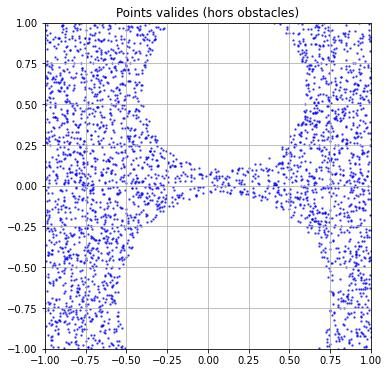

In [ ]:
sampler = ObstacleSampler()
samples = sampler.sample_x0(num_samples=3000)
